<a href="https://colab.research.google.com/github/SLKS99/Exploring-the-Evolution-of-Metal-Halide-Perovskites-via-Latent-Representations-of-the-Photoluminesce/blob/main/MAPbI3_%2B_FAPbBr3_Chloroform_VAE%2C_tVAE%2C_cVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

June 16, 2022


Contributions:
- Data by Mahshid Ahmadi and Sheryl Sanchez

- AtomAI and PyroVED by Maxim Ziatdinov
- Workflow by Sergei Kalinin

\

- pytorch: 1.12.1+cu101
- pyro: 0.1.1
- pyroved:0.2.3

In [ ]:
#@title Import Modules 
!pip install lmfit
import os
import glob
import numpy as np
import pandas as pd

#Machine Learning Tools
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler


from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#Peak Finding
from scipy.stats import norm, multivariate_normal
import scipy.signal as ss

#Plotting Tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from numpy import exp, pi, sqrt
from matplotlib import rcParams
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from skimage.util.dtype import img_as_float32
from copy import deepcopy as dc
!pip install numpy --upgrade

import numpy as np
import torch


from scipy import ndimage
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from seaborn import heatmap
import seaborn as sns

from mpl_toolkits import mplot3d
#gdown Installation
!pip install gdown==3.6.0
!pip install lmfit
from lmfit import Model
from lmfit import minimize

!pip install atomai pyroved
!pip install pyroved==0.2.3
import pyroved as pv
import atomai as aoi



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 13.7 MB/s 
     |████████████████████████████████| 98 kB 7.2 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84413 sha256=d10762160ca8f05f2ccac2cd9701a7851ae5d21999aa1f82e1820d4aab37d900
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
Successfully built lmfit
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gdown: filename=gdown-3.6.0-py3-none-any.whl size=5235 sha256=8694a0c5db217b5084338d4c5ad1fac62b53e435941e6310d7219279422213e8
  Stored in directory: /root/.cache/pip/wheels/fa/16/df/0fd498965fab234700f8805ede80d6fd525a6fa306306a9f41
Successfully built gdown
  Attempting uninstall: gdown


## User Input

In [ ]:
#@title Experimental Data 

#Names of Precursors
precursor1 = '$MAPbI_3$' #@param {type:"string"}
precursor2 = '$FAPbBr_33$' #@param {type:"string"}

#Wells that we should ignore
wells_to_ignore = '' #@param {type:"string"}

#Information about Measurement Range
start_wavelength = 500 #@param {type:"integer"}
end_wavelength =  850 #@param {type:"integer"}
wavelength_step_size =  2 #@param {type:"integer"}

time_step = 10 #@param {type:"integer"}

#Information about the reads
number_of_reads =   60 #@param {type:"integer"}
luminescence_read_numbers = '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60' #@param {type:"string"}

#Convert the string into a list to use later 
if len(wells_to_ignore) != 0:
  wells_to_ignore = list(wells_to_ignore.split(","))
luminescence_read_numbers = list(luminescence_read_numbers.split(","))

In [ ]:
#@title Data Information

#Name of files 
data_file_name = '5-27-22 MAPbI3 FAPbBr3 chloroform (1).csv' #@param {type:'string'}
composition_file_name = '0.0 - Compositions.csv' #@param {type:'string'}

#Download the correct data
data_file = '1KCaIjtQvUOjgknpvZ3EJrsufYDcQc1o-' #@param {type:"string"}
composition_file = '1yBVvZhv-4qdR24JMsYADjQ_mi3CaqLh1' #@param {type:"string"}

## Downloading and Formating Data

In [ ]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file}

!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=1KCaIjtQvUOjgknpvZ3EJrsufYDcQc1o-
To: /content/5-27-22 MAPbI3 FAPbBr3 chloroform (1).csv
100% 2.94M/2.94M [00:00<00:00, 198MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yBVvZhv-4qdR24JMsYADjQ_mi3CaqLh1
To: /content/0.0 - Compositions.csv
100% 1.05k/1.05k [00:00<00:00, 1.79MB/s]


In [ ]:
#@title Into Pandas Dataframes
rawData = pd.read_csv(data_file_name,header=None)
rawData = rawData.replace('OVRFLW', np.NaN)

composition = pd.read_csv(composition_file_name, index_col = 0)



In [ ]:
#@title Parsing the Data into a Dictionary
cells = [] 

for i in range(1, 9):
  for j in range(1 , 13): 
    cells.append(chr(64 + i) + str(j))
if not wells_to_ignore:
  for i in wells_to_ignore:
    cells.remove(i)
if not luminescence_read_numbers:
  for i in luminescence_read_numbers:
    cells.remove(i)


for i in wells_to_ignore: 
  composition = composition.drop(i, axis = 1)

#First the rows of measurements 
rows = []

for i in range(1, number_of_reads + 1): 
  
  rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':EM Spectrum'].index.tolist()

rows += rawData[rawData[rawData.columns[0]] == 'Results'].index.tolist()

#Separate into different dataframes 

#First step, make a list of the names 
names = []

for i in range(1, number_of_reads + 1):
  names.append('Read ' + str(i))

#Next, make a dictionary 
d = {}

for c in names:
  split_name = c.split(' ')
  index = int(split_name[1])
  d[c] = rawData[rows[index - 1] + 2 :rows[index] - 1] #Take a section of the values 
  d[c] = d[c].drop([0], axis = 1) #Drop the empty column
  new_header = d[c].iloc[0] #grab the first row for the header
  d[c] = d[c][1:] #take the data less the header row
  d[c].columns = new_header #set the header row as the df header
  for i in wells_to_ignore: 
    d[c] = d[c].drop(i, axis = 1)
  d[c] = d[c].astype(float) #Make sure that it is composed of numbers
  
  

In [ ]:
d[c].describe()

11117  Wavelength           A1          A2            A3           A4  \
count  176.000000   176.000000  176.000000    176.000000   176.000000   
mean   675.000000   721.687500  107.187500   1322.011364   437.596591   
std    101.901914  1749.599889  234.789423   3181.897326  1035.648805   
min    500.000000     0.000000    0.000000      0.000000     0.000000   
25%    587.500000     0.000000    3.000000      2.000000     1.000000   
50%    675.000000     3.500000    5.000000      6.000000     6.500000   
75%    762.500000   137.750000   39.250000    247.500000    97.000000   
max    850.000000  7090.000000  947.000000  13258.000000  4238.000000   

11117           A5            A6            A7            A8            A9  \
count   176.000000    176.000000    176.000000    176.000000    176.000000   
mean    247.284091   1187.392045   1497.261364   1709.835227   2309.659091   
std     582.489631   2870.026435   3610.784817   4151.732399   5632.477276   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%       0.000000      0.750000      0.000000      0.000000      1.750000   
50%       3.500000      3.000000      3.000000      8.000000      8.000000   
75%      61.750000    221.000000    293.750000    309.750000    396.500000   
max    2367.000000  11792.000000  14807.000000  17238.000000  23862.000000   

11117  ...          H3          H4          H5          H6          H7  \
count  ...  176.000000  176.000000  176.000000  176.000000  176.000000   
mean   ...   24.795455    8.755682    7.744318   16.835227   52.602273   
std    ...   44.446992   18.273243   15.612723   32.464154  103.528827   
min    ...    0.000000    0.000000    0.000000    0.000000    0.000000   
25%    ...    0.000000    0.000000    0.000000    0.000000    0.000000   
50%    ...    1.000000    0.000000    0.000000    1.000000    0.000000   
75%    ...   24.000000    5.000000    5.250000   14.000000   30.500000   
max    ...  156.000000   74.000000   62.000000  123.000000  359.000000   

11117          H8          H9         H10         H11         H12  
count  176.000000  176.000000  176.000000  176.000000  176.000000  
mean    54.426136   48.221591   57.329545   48.636364   48.125000  
std    105.388832   94.029246  111.344636   95.358413   93.094092  
min      0.000000    0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000    0.000000    0.000000  
75%     37.500000   32.000000   40.500000   32.250000   31.000000  
max    365.000000  335.000000  388.000000  328.000000  329.000000  

[8 rows x 97 columns]

In [ ]:
from tabulate import tabulate
df_styled= composition.style.background_gradient()
df_styled

In [ ]:
#@title Convert the Dictionary into an Array
#Convert  into an array
luminescence_time = np.array(luminescence_read_numbers)
luminescence_time = [int(i) * time_step for i in luminescence_time]

#Convert wavelength information into an array
luminescence_wavelength = np.arange(start_wavelength,end_wavelength + wavelength_step_size,wavelength_step_size)

#Make a grid
nx, ny = np.meshgrid(luminescence_wavelength, luminescence_time)

#Load information into a dataframe
luminescence_df = pd.DataFrame()

for i in luminescence_read_numbers:
  
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])

luminescence_df.insert(loc = 0, column = 'Time', value = ny.ravel())

luminescence_df = luminescence_df.fillna(0.0)




## Time evolution plot

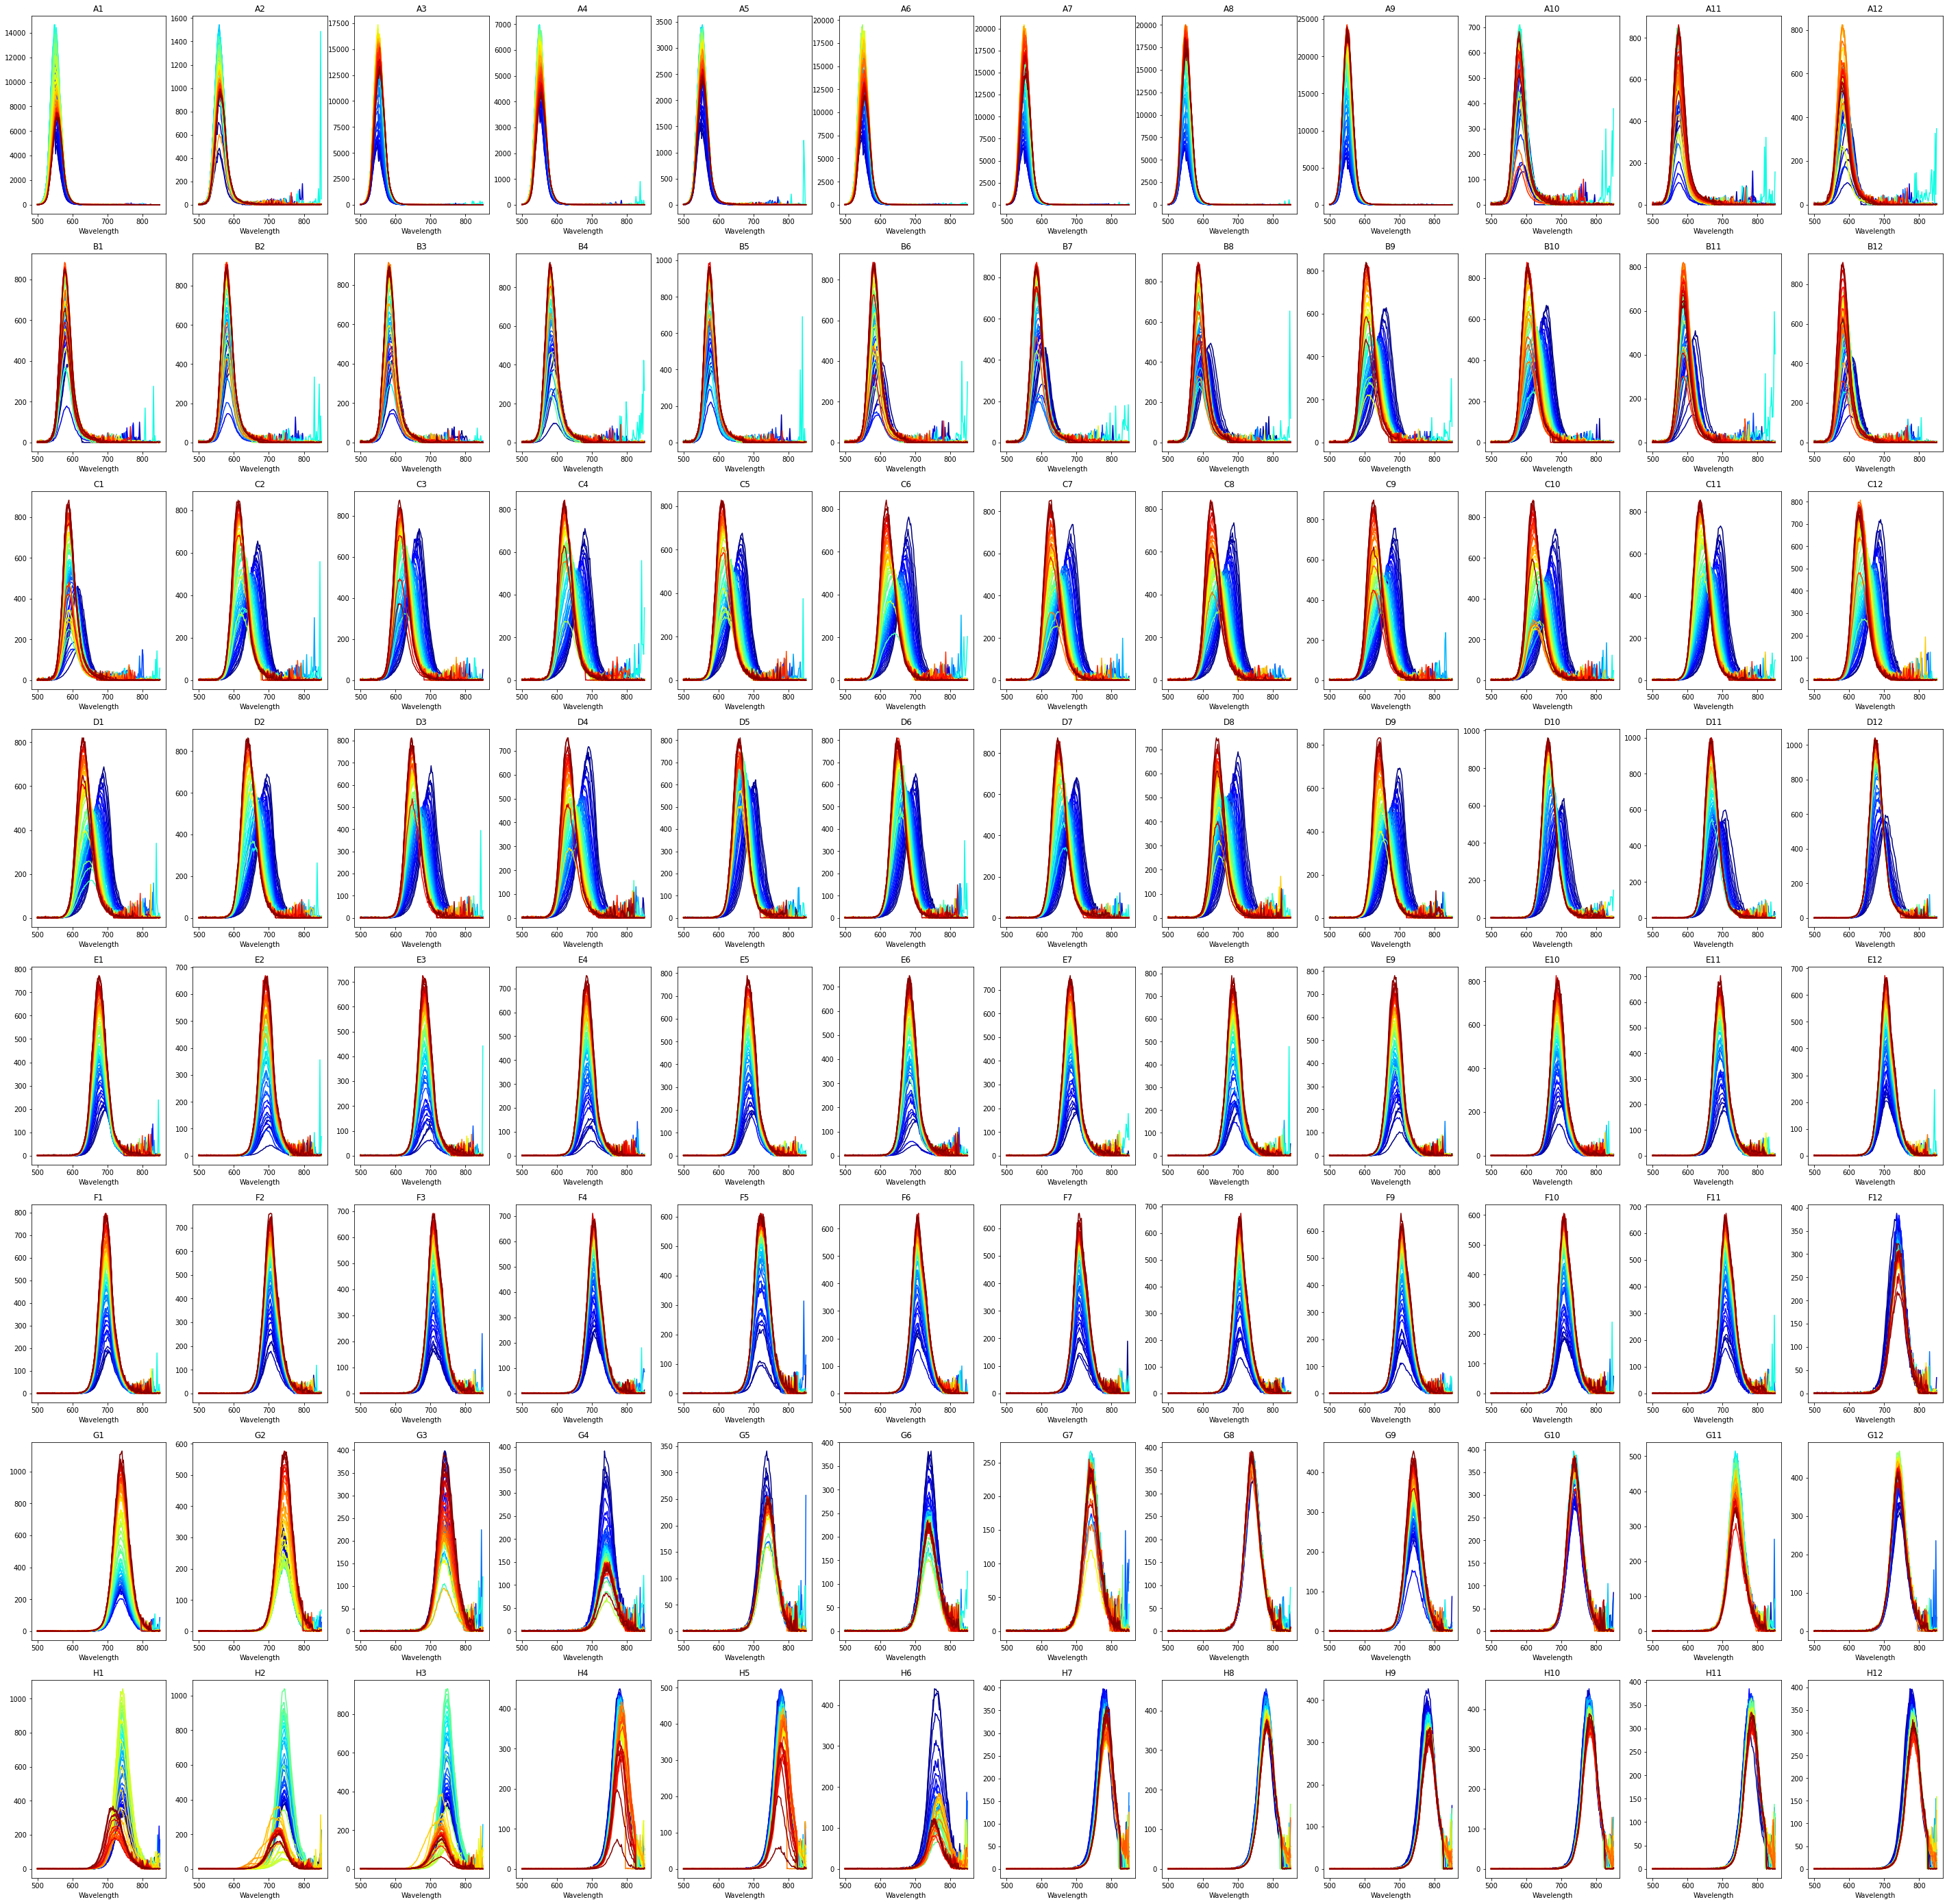

In [ ]:
#@title Time Evolution for Luminescence

num_of_rows = 8
num_of_cols = 12

#Define the figure
fig, axes = plt.subplots(nrows = num_of_rows , ncols = num_of_cols, figsize = (50,50))

colors = cm.jet(np.linspace(0, 1, len(luminescence_read_numbers)))

for i in range(len(luminescence_read_numbers)): 
  
  plot_row = 0
  plot_column = 0

  for j in range(96): 
    if cells[j] not in wells_to_ignore:
      d['Read '+ str(luminescence_read_numbers[i])].plot(x = 'Wavelength', y = cells[j], ax = axes[plot_row, plot_column], title = str(cells[j]), legend = False, c = colors[i])
    

    #Putting the plots where they need to be 
    plot_column += 1
    if plot_column == 12:
      plot_row += 1
      plot_column = 0
plt.savefig('Time evolution plot.tif', bbox_inches='tight',dpi=300)

## Variational autoencoder analysis

(60, 176, 96)
(96, 60, 176)


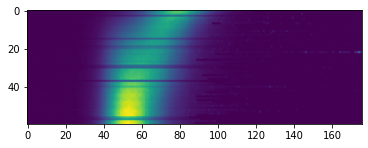

In [ ]:
# Note: we have 50 time points, 71 wavelength points, and 97 wells/compositions
# In analysis, we treat time/wavelength as axis on which we perform transform, and composition as space
scaler = MinMaxScaler()
luminescence_vec_norm = scaler.fit_transform(luminescence_df)

dataset = luminescence_vec_norm[:,2:]
dataset = dataset.reshape(len(luminescence_time), len(luminescence_wavelength),96)
print(dataset.shape)
dataset = np.transpose(dataset, (2,0,1))

dataset = dataset.astype(np.float64)
print(dataset.shape)
plt.imshow(dataset[20, :,:])

d1, d2, d3 = dataset.shape

In [ ]:
hdata = dataset
hdata = hdata.astype(np.float64)

# PCA and NMF

In [ ]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
#X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

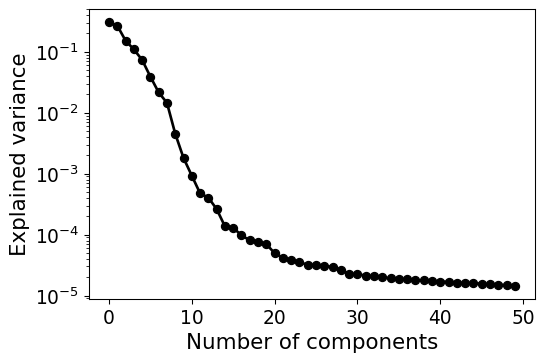

In [ ]:
pca = decomposition.PCA()
pca.fit(X_vec)
plt.figure(figsize=(6, 4), dpi = 96)
plt.plot(pca.explained_variance_ratio_[0:50], '-o', linewidth=2, c = 'black')
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Explained variance', fontsize = 16)

plt.tick_params(labelsize = 14)
plt.yscale('log')

In [ ]:
# Select number of components
nc = 3

# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'NMF'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


(3, 176) (5760, 3)


NUMBER OF COMPONENTS: 3
Components...


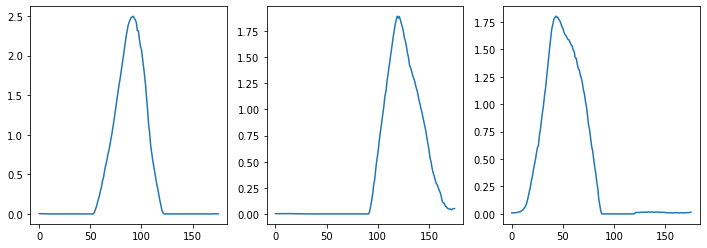

Abundance maps...


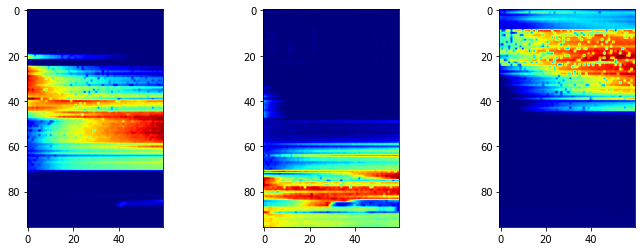

In [ ]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    ax1.plot(components[i])
    #ax1.set_title('Component ' + str(i + 1))
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    #ax2.set_title('Component ' + str(i + 1))
plt.show()

# VAE analysis

In [ ]:
luminescence= luminescence_df.drop(['Time'],axis=1).drop(['Wavelength'],axis=1)

In [ ]:
scaler= MinMaxScaler()
arr_scaled = scaler.fit_transform(luminescence) 
luminescence_norm = pd.DataFrame(arr_scaled, columns=luminescence.columns,index=luminescence.index)

print(luminescence_norm.describe())

luminescence=np.array(luminescence)

                 A1            A2            A3            A4            A5  \
count  10560.000000  10560.000000  10560.000000  10560.000000  10560.000000   
mean       0.068319      0.078540      0.075071      0.079857      0.082584   
std        0.173241      0.183263      0.191407      0.196536      0.200921   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000546      0.003238      0.000518      0.000859      0.001740   
75%        0.012413      0.025907      0.013199      0.015755      0.018852   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 A6            A7            A8            A9           A10  \
count  10560.000000  10560.000000  10560.000000  10560.000000  10560.000000   
mean       0.074583      0.071497      0.071820      0.070203      0.096743   
std        0.188682      0.185259      0.188008    

(60, 176, 96)
(96, 60, 176)


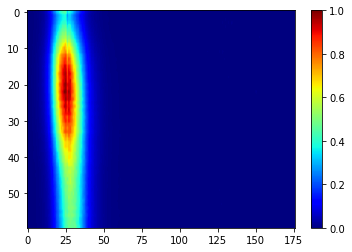

In [ ]:


dataset = np.array(luminescence_norm)
#dataset=luminesence
dataset = dataset.reshape(len(luminescence_time), len(luminescence_wavelength),96)
dataset = dataset[:,:,:]
print(dataset.shape)
dataset = np.transpose(dataset, (2,0,1))

dataset = dataset.astype(np.float64)

print(dataset.shape)
show=plt.imshow(dataset[0,:,:], cmap='jet',aspect='auto')
plt.colorbar(show)
hdata = dataset.copy()
s1, s2, s3 = hdata.shape
hdata = hdata.reshape(s1*s2,s3)


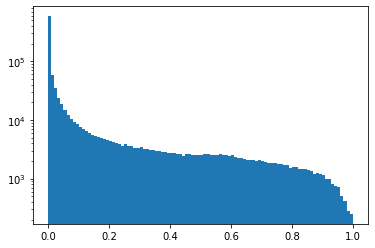

In [ ]:

plt.hist(hdata.flatten(), bins=100);
plt.semilogy();


In [ ]:
train_data= hdata

#n_samples = train_data.shape[0] # number of samples
l_signal = train_data.shape[1] # signal length

train_data = torch.tensor(train_data).float()
x = torch.linspace(-5, 5, l_signal)

# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

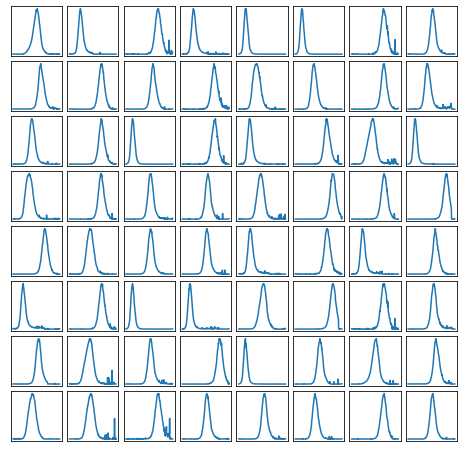

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                        subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x, y[0,0])
    #ax.set_ylim(0, 1)

### 2D latent space

##VAE

In [ ]:
in_dim = (l_signal,)

# Initialize vanilla VAE
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances= None, sampler_d='gaussian', decoder_sig=0.01, seed=42) #['t']

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(50):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: 50595.0624
Epoch: 2 Training loss: 27798.6866
Epoch: 3 Training loss: 9670.2649
Epoch: 4 Training loss: 1734.7403
Epoch: 5 Training loss: 561.5511
Epoch: 6 Training loss: 235.7342
Epoch: 7 Training loss: 86.1601
Epoch: 8 Training loss: 7.8792
Epoch: 9 Training loss: -56.6064
Epoch: 10 Training loss: -104.8905
Epoch: 11 Training loss: -133.0275
Epoch: 12 Training loss: -160.2643
Epoch: 13 Training loss: -194.2042
Epoch: 14 Training loss: -202.5380
Epoch: 15 Training loss: -216.1028
Epoch: 16 Training loss: -234.8348
Epoch: 17 Training loss: -239.3653
Epoch: 18 Training loss: -263.4681
Epoch: 19 Training loss: -273.3079
Epoch: 20 Training loss: -283.6796
Epoch: 21 Training loss: -296.0313
Epoch: 22 Training loss: -297.7159
Epoch: 23 Training loss: -321.8771
Epoch: 24 Training loss: -322.2005
Epoch: 25 Training loss: -336.8835
Epoch: 26 Training loss: -339.9752
Epoch: 27 Training loss: -329.5520
Epoch: 28 Training loss: -356.4184
Epoch: 29 Training loss: -341.7012


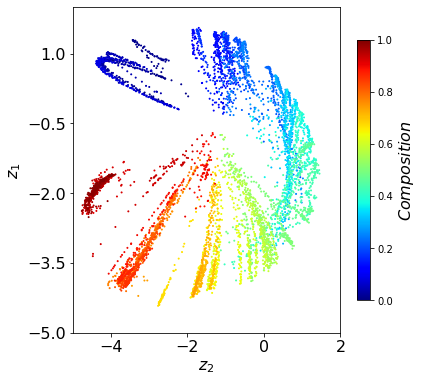

In [ ]:

z_mean, z_sd = vae.encode(train_data)

Z1_array= np.array(z_mean[:,-1])
Z2_array= np.array(z_mean[:, -2])

color=(np.linspace(0,1,len(Z2_array)))

fig, (ax1)= plt.subplots (1,figsize=(6,6))
im1= ax1.scatter(z_mean[:, -1], z_mean[:, -2], c=color, cmap=plt.cm.get_cmap('jet'), s=1)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Composition$", fontsize=16)
ax1.set_xlabel("$z_2$", fontsize=16)
ax1.set_ylabel("$z_1$", fontsize=16)

ax1.tick_params(axis='both',labelsize=16)
ax1.set_yticks(np.arange(-5,2,1.5))
ax1.set_xlim(-5, 2)
ax1.set_ylim(-5, 2)




clrbar = np.linspace(hdata[:,0].min(), hdata[:,0].max()).reshape(-1, 1)


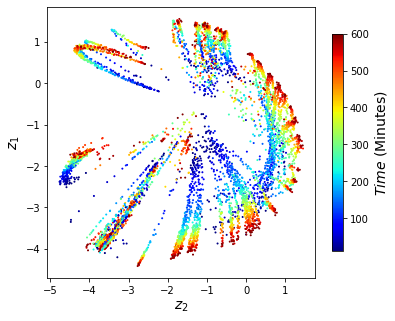

In [ ]:
z_mean, z_sd = vae.encode(train_data)
fig, (ax1)= plt.subplots (1,figsize=(6,5))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=luminescence_time*96, cmap='jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Time$ (Minutes)", fontsize=14)





plt.savefig('VAE Latent Space time.tif', bbox_inches='tight',dpi=300)

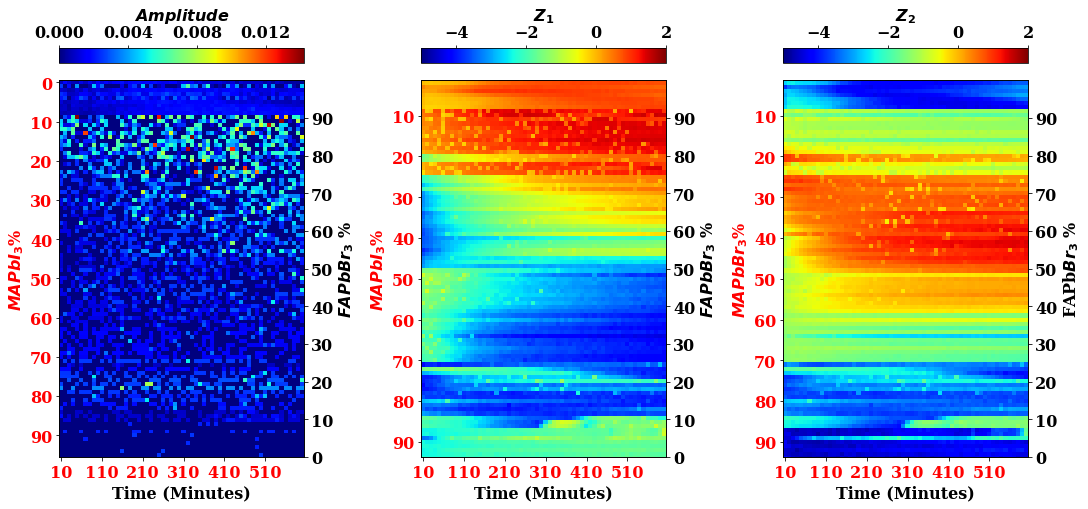

In [ ]:
import matplotlib.ticker as ticker
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

f, (ax1,ax2,ax3) = plt.subplots( 1,3,figsize=(15, 6),constrained_layout = True)


im1 = ax1.imshow(hdata[:,0].reshape(s1,s2), cmap='jet',aspect='auto')

ax1.set_xticks(np.arange(0,len(luminescence_time),10))
ax1.set_xticklabels(luminescence_time[0::10])
ax1.set_xlabel('Time (Minutes)')
ax1.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax1.set_ylabel('$MAPbI_3 $%',color='red')

ax1.tick_params(axis='both', labelcolor='red')
axins = inset_axes(ax1,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal',cax=axins,spacing='proportional')
tick_locator = ticker.MaxNLocator(nbins=4)
cbar1.locator = tick_locator
cbar1.update_ticks()
cbar1.set_label(label='$Amplitude$')
axins.xaxis.tick_top()
cbar1.ax.xaxis.set_label_position('top')

ax=ax1.twinx()
coolor= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)



#---------------------------------------------------------------------------------
im2 = ax2.imshow(z_mean[:, 0].reshape(s1,s2), cmap='jet',vmin=-5,vmax=2)

ax2.set_xticks(np.arange(0,len(luminescence_time),10))
ax2.set_xticklabels(luminescence_time[0::10])
ax2.set_xlabel('Time (Minutes)')
ax2.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax2.set_ylabel('$MAPbI_3 $%',color='red')
ax2.tick_params(axis='both',labelcolor='red')

axins = inset_axes(ax2,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal',cax=axins,spacing='proportional')

cbar2.set_label(label='$Z_1$')
axins.xaxis.tick_top()
cbar2.ax.xaxis.set_label_position('top')



ax=ax2.twinx()
color= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)


#-----------------------------------------------------------------------

im3 = ax3.imshow(z_mean[:, 1].reshape(s1,s2), cmap='jet',vmin=-5, vmax=2)
ax3.set_xticks(np.arange(0,len(luminescence_time),10))
ax3.set_xticklabels(luminescence_time[0::10])
ax3.set_xlabel('Time (Minutes)')
ax3.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax3.set_ylabel('$MAPbBr_3 $%',color='red')
ax3.tick_params(axis='both',labelcolor='red')
axins = inset_axes(ax3,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar3 = fig.colorbar(im3, ax=ax3, orientation='horizontal',cax=axins,spacing='proportional')
#tick_locator3 = ticker.MaxNLocator(nbins=7)
#cbar3.locator = tick_locator3
#cbar3.update_ticks()
cbar3.set_label(label='$Z_2$')
axins.xaxis.tick_top()
cbar3.ax.xaxis.set_label_position('top')

ax=ax3.twinx()
color= 'black'
ax.set_ylabel("FAPb$Br_3$ %", color=color,fontweight='bold')
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)


f.savefig('VAE Latent Space plot.tif', bbox_inches='tight',dpi=300)



Gaussian Fit

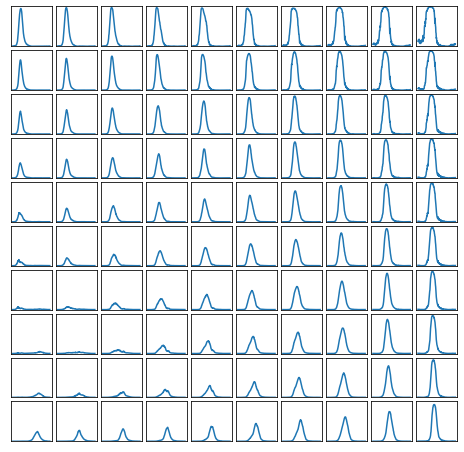

In [ ]:
n=10


f_vae=vae.manifold2d(d=n,ylim=[0,1]); #z_coord = [-2,0,0,2], 

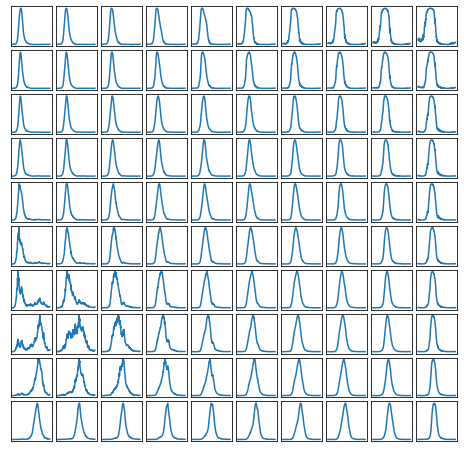

In [ ]:
n=10


f_vae=vae.manifold2d(d=n); #z_coord = [-2,0,0,2], 

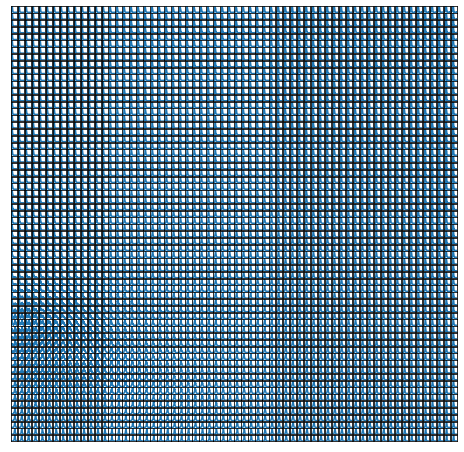

In [ ]:
n=64


f_vae=vae.manifold2d(d=n); #z_coord = [-2,0,0,2], 

In [ ]:
def gauss(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))

def ls_parameters(f, n):         #f: manifold2d; n: grid number
  x = np.linspace (-5, 5, l_signal)
  gmodel = Model(gauss)
  latent_peak = np.zeros((n*n, 6))

  for i in range (n*n):
    y = np.array(f[i])
    mx = y.max()
    y = (y-y.min())/(y.max()-y.min())
    
    a = y.max()
    #center = np.float(x[np.where(y == a)])
    c = sum(x * y) / sum(y)
    w = np.sqrt(sum(y * (x - c)**2) / sum(y))

    params = gmodel.make_params(cen=c, amp=a, wid=w)
    result = gmodel.fit(y, params, x=x)

    print(result.fit_report())
    para=result.fit_report()
    #result.params.pretty_print()
    
    amp_fit = result.params['amp'].stderr
   
    fit_amp = (amp_fit)

    cen_fit= result.params['cen'].stderr
    fit_cen = (cen_fit)
    wid_fit= result.params['wid'].stderr
    fit_wid = (wid_fit)
    yerr = result.eval_uncertainty()
    idx_amp = para.index('amp')
    d_am = para[idx_amp+6:idx_amp+16] 
    d_amp = np.float(d_am)

    idx_mu = para.index('cen')
    d_m = para[idx_mu+6:idx_mu+16]
    d_mu = np.float(d_m)

    idx_w = para.index('wid')
    d_s = para[idx_w+6:idx_w+16]
    d_sig = np.float(d_s)

    d_a = d_amp / (sqrt(2*pi) * d_sig) * mx
    latent_peak [i,] = d_a, d_mu, d_sig, fit_amp,fit_cen,fit_wid
    
  
  l_a = latent_peak[:,0] 
  a_map = np.reshape(l_a, (n,n))
  l_mu = latent_peak[:,1] 
  mu_map = np.reshape(l_mu, (n,n))
  l_sig = latent_peak[:,2] 
  sig_map = np.reshape(l_sig, (n,n))
  f_amp= latent_peak[:,3]
  amp_fmap=np.reshape(f_amp,(n,n))
  f_cen= latent_peak[:,4]
  cen_fmap=np.reshape(f_cen,(n,n))
  f_wid= latent_peak[:,5]
  wid_fmap=np.reshape(f_wid,(n,n))
  

  return a_map, mu_map, sig_map,amp_fmap,cen_fmap,wid_fmap
  







In [ ]:
#vae latent space
a_map, mu_map, sig_map,amp_fmap,cen_fmap,wid_fmap= ls_parameters(f_vae, n)     #input VAE manifold2D and grid number to the function ls_parameters and return intensity, shift, and width maps



[[Model]]
    Model(gauss)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 176
    # variables        = 3
    chi-square         = 0.07820173
    reduced chi-square = 4.5203e-04
    Akaike info crit   = -1352.53477
    Bayesian info crit = -1343.02332
[[Variables]]
    amp:  1.25439982 +/- 0.00823013 (0.66%) (init = 1)
    cen: -2.77900335 +/- 0.00373618 (0.13%) (init = -2.647552)
    wid:  0.49316328 +/- 0.00373618 (0.76%) (init = 0.8341367)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577
[[Model]]
    Model(gauss)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 176
    # variables        = 3
    chi-square         = 0.08269352
    reduced chi-square = 4.7800e-04
    Akaike info crit   = -1342.70525
    Bayesian info crit = -1333.19380
[[Variables]]
    amp:  1.26296653 +/- 0.00849740 (0.67%) (init = 1)
    cen: -2.74243078 +/- 0.00386237 (0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.float` is a deprecated alias for 

Streaming output truncated to the last 5000 lines.
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577
[[Model]]
    Model(gauss)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 176
    # variables        = 3
    chi-square         = 0.26285160
    reduced chi-square = 0.00151937
    Akaike info crit   = -1139.17034
    Bayesian info crit = -1129.65889
[[Variables]]
    amp:  1.88192118 +/- 0.01923203 (1.02%) (init = 1)
    cen: -0.15924094 +/- 0.00945419 (5.94%) (init = -0.2010587)
    wid:  0.80118806 +/- 0.00945419 (1.18%) (init = 0.9654125)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577
[[Model]]
    Model(gauss)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 176
    # variables        = 3
    chi-square         = 0.25510775
    reduced chi-square = 0.00147461
    Akaike info crit   = -1144.43337
    Bayesian i

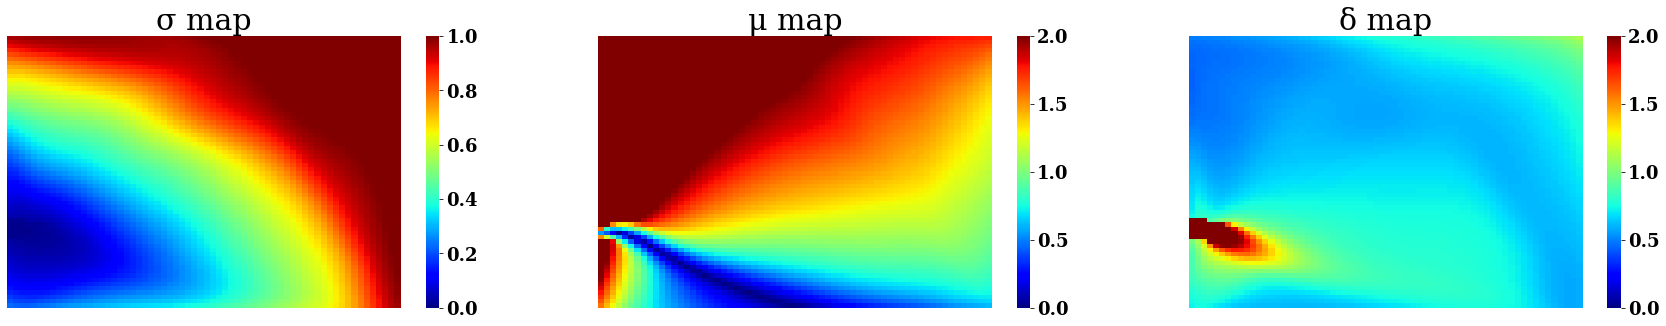

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "18"
plt.rcParams["axes.labelweight"] = "bold"

#plt intensity, shift, and width maps
fig, (ax1,ax2,ax3)= plt.subplots (nrows=1,ncols=3,figsize=(30,5))
ax1 = heatmap(a_map,cmap= "jet",vmin=0,vmax=1,ax=ax1)
ax1.set_title ('σ map',fontsize=30)
ax1.set_yticks([])
ax1.set_xticks([])

ax2 = heatmap(mu_map,cmap= "jet", vmin=0,vmax=2,ax=ax2)
ax2.set_title ('μ map',fontsize=30)

ax2.set_yticks([])
ax2.set_xticks([])


ax3 = heatmap(sig_map,cmap= "jet",vmin=0,vmax=2,ax=ax3)
ax3.set_title ('δ map',fontsize=30)
ax3.set_yticks([])
ax3.set_xticks([])

plt.show()

fig.savefig('VAE .tif', bbox_inches='tight',dpi=300)

    


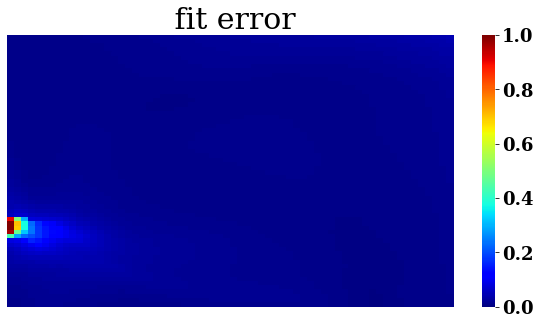

In [ ]:

fig, (ax1)= plt.subplots (nrows=1,ncols=1,figsize=(10,5))
ax1 = heatmap(amp_fmap,cmap= "jet",vmin=0,vmax=1,ax=ax1)
ax1.set_title (' fit error',fontsize=30)
ax1.set_yticks([])
ax1.set_xticks([])


fig.savefig('VAE fit error .tif', bbox_inches='tight',dpi=300)



##tVAE

In [ ]:
in_dim = (l_signal,)

# Initialize vanilla VAE
tvae = pv.models.iVAE(in_dim, latent_dim=2, invariances= ['t'], sampler_d='gaussian', decoder_sig=0.01 ,seed=42) #['t']

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(tvae)

# Train for n epochs:
for e in range(50):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 40428.9497
Epoch: 2 Training loss: 21082.6249
Epoch: 3 Training loss: 3820.9599
Epoch: 4 Training loss: 895.2919
Epoch: 5 Training loss: 707.9422
Epoch: 6 Training loss: 469.4265
Epoch: 7 Training loss: 388.5125
Epoch: 8 Training loss: 236.6534
Epoch: 9 Training loss: 179.4857
Epoch: 10 Training loss: 151.6133
Epoch: 11 Training loss: 26.6717
Epoch: 12 Training loss: -0.2290
Epoch: 13 Training loss: -51.6178
Epoch: 14 Training loss: -104.2002
Epoch: 15 Training loss: -117.9627
Epoch: 16 Training loss: -115.7861
Epoch: 17 Training loss: -195.3670
Epoch: 18 Training loss: -223.1379
Epoch: 19 Training loss: -225.0612
Epoch: 20 Training loss: -234.1238
Epoch: 21 Training loss: -280.4835
Epoch: 22 Training loss: -288.4999
Epoch: 23 Training loss: -319.7461
Epoch: 24 Training loss: -294.3955
Epoch: 25 Training loss: -334.3759
Epoch: 26 Training loss: -336.3526
Epoch: 27 Training loss: -336.5070
Epoch: 28 Training loss: -336.7860
Epoch: 29 Training loss: -331.2496
Epoc

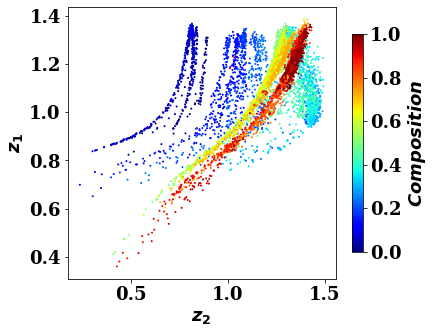

In [ ]:
z_mean, z_sd = tvae.encode(train_data)
Z1_array= np.array(z_mean[:,-1])
Z2_array= np.array(z_mean[:, -2])

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "18"
plt.rcParams["axes.labelweight"] = "bold"
color=(np.linspace(0,1,len(Z2_array)))
fig, (ax1)= plt.subplots (1,figsize=(6,5))
im1= ax1.scatter(Z1_array, Z2_array, c=color, cmap=plt.cm.get_cmap('jet'), s=1)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Composition$",fontsize=18, weight='bold')
ax1.set_xlabel("$z_2$",weight='bold')
ax1.set_ylabel("$z_1$",weight='bold')
 
ax1.tick_params(axis='both')
plt.savefig('tVAE Latent Space Composition.tif', bbox_inches='tight',dpi=300)

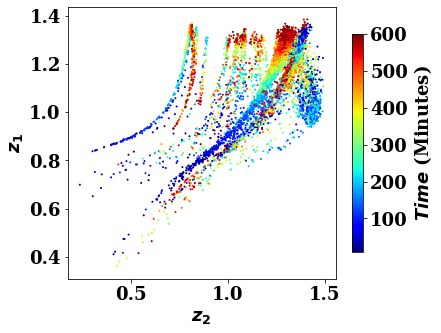

In [ ]:
z_mean, z_sd = tvae.encode(train_data)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "18"
plt.rcParams["axes.labelweight"] = "bold"
fig, (ax1)= plt.subplots (1,figsize=(6,5))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=luminescence_time*96, cmap='jet')
ax1.set_xlabel("$z_2$",fontsize=18)
ax1.set_ylabel("$z_1$",fontsize=18)

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Time$ (Minutes)", fontsize=18)


plt.savefig('tVAE Latent Space time.tif', bbox_inches='tight',dpi=300)


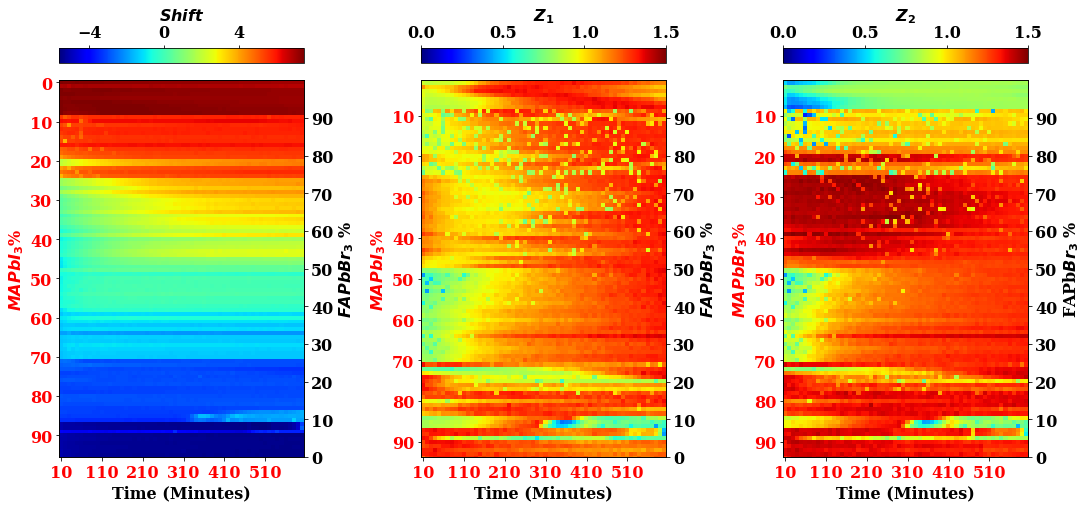

In [ ]:
from skimage.util.dtype import img_as_float32

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"



f, (ax1,ax2,ax3) = plt.subplots( 1,3,figsize=(15, 6),constrained_layout = True)


im1 = ax1.imshow(z_mean[:,0].reshape(s1,s2), cmap='jet',aspect='auto')

ax1.set_xticks(np.arange(0,len(luminescence_time),10))
ax1.set_xticklabels(luminescence_time[0::10])
ax1.set_xlabel('Time (Minutes)')
ax1.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax1.set_ylabel('$MAPbI_3 $%',color='red')

ax1.tick_params(axis='both', labelcolor='red')
axins = inset_axes(ax1,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal',cax=axins,spacing='proportional')
tick_locator = ticker.MaxNLocator(nbins=4)
cbar1.locator = tick_locator
cbar1.update_ticks()
cbar1.set_label(label='$Shift$')
axins.xaxis.tick_top()
cbar1.ax.xaxis.set_label_position('top')

ax=ax1.twinx()
coolor= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)



#---------------------------------------------------------------------------------
im2 = ax2.imshow(z_mean[:, 1].reshape(s1,s2), cmap='jet',vmin=0,vmax=1.5)

ax2.set_xticks(np.arange(0,len(luminescence_time),10))
ax2.set_xticklabels(luminescence_time[0::10])
ax2.set_xlabel('Time (Minutes)')
ax2.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax2.set_ylabel('$MAPbI_3 $%',color='red')
ax2.tick_params(axis='both',labelcolor='red')

axins = inset_axes(ax2,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal',cax=axins,spacing='proportional')

cbar2.set_label(label='$Z_1$')
axins.xaxis.tick_top()
cbar2.ax.xaxis.set_label_position('top')



ax=ax2.twinx()
color= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)


#-----------------------------------------------------------------------

im3 = ax3.imshow(z_mean[:, 2].reshape(s1,s2), cmap='jet',vmin=0,vmax=1.5)
ax3.set_xticks(np.arange(0,len(luminescence_time),10))
ax3.set_xticklabels(luminescence_time[0::10])
ax3.set_xlabel('Time (Minutes)')
ax3.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax3.set_ylabel('$MAPbBr_3 $%',color='red')
ax3.tick_params(axis='both',labelcolor='red')
axins = inset_axes(ax3,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar3 = fig.colorbar(im3, ax=ax3, orientation='horizontal',cax=axins,spacing='proportional')
#tick_locator3 = ticker.MaxNLocator(nbins=7)
#cbar3.locator = tick_locator3
#cbar3.update_ticks()
cbar3.set_label(label='$Z_2$')
axins.xaxis.tick_top()
cbar3.ax.xaxis.set_label_position('top')

ax=ax3.twinx()
color= 'black'
ax.set_ylabel("FAPb$Br_3$ %", color=color,fontweight='bold')
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)


f.savefig('tVAE Latent Space plot.tif', bbox_inches='tight',dpi=300)



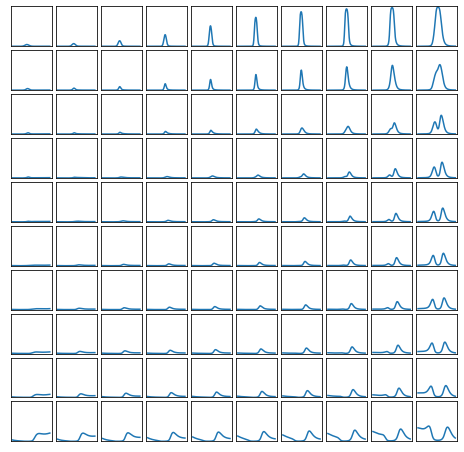

In [ ]:
b=10

t_vae=tvae.manifold2d(d=b,ylim=[0,1]); #z_coord = [-2,0,0,2], 

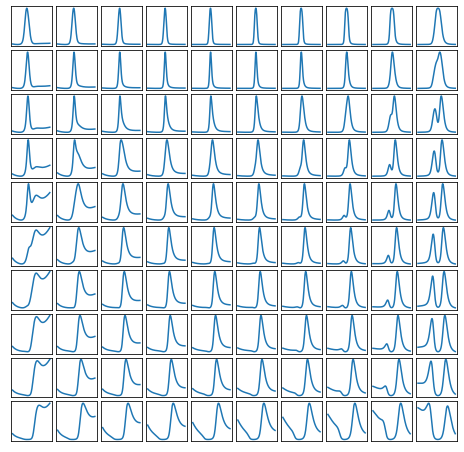

In [ ]:
b=10

t_vae=tvae.manifold2d(d=b);

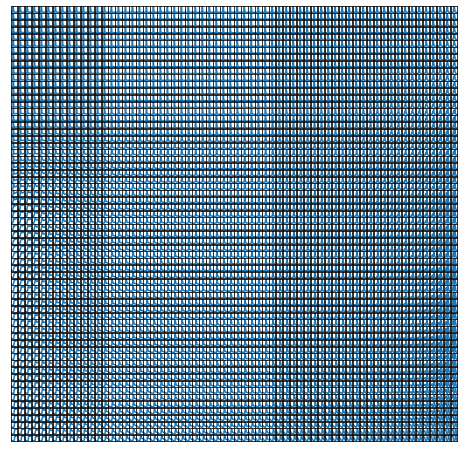

In [ ]:
b=64

t_vae=tvae.manifold2d(d=b); #z_coord = [-2,0,0,2], 

Gaussian Fit

In [ ]:
def gauss(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))

def ls_parameters(f, b):         #f: manifold2d; n: grid number
  x = np.linspace (-5, 5, l_signal)
  gmodel = Model(gauss)
  latent_peak = np.zeros((b*b, 6))

  for i in range (b*b):
    y = np.array(f[i])
    mx = y.max()
    y = (y-y.min())/(y.max()-y.min())
    
    a = y.max()
    #center = np.float(x[np.where(y == a)])
    c = sum(x * y) / sum(y)
    w = np.sqrt(sum(y * (x - c)**2) / sum(y))

    params = gmodel.make_params(cen=c, amp=a, wid=w)
    result = gmodel.fit(y, params, x=x)

    para=result.fit_report()
    amp_fit = result.params['amp'].stderr
   
    fit_amp = (amp_fit)

    cen_fit= result.params['cen'].stderr
    fit_cen =(cen_fit)
    wid_fit= result.params['wid'].stderr
    fit_wid = (wid_fit)
    
    idx_amp = para.index('amp')
    d_am = para[idx_amp+6:idx_amp+16] 
    d_amp = np.float(d_am)
   

    idx_amp = para.index('amp')
    d_am = para[idx_amp+6:idx_amp+16] # whats the purpose of adding the 6 and 16?
    d_amp = np.float(d_am)

    idx_mu = para.index('cen')
    d_m = para[idx_mu+6:idx_mu+16]
    d_mu = np.float(d_m)

    idx_w = para.index('wid')
    d_s = para[idx_w+6:idx_w+16]
    d_sig = np.float(d_s)

    d_a = d_amp / (sqrt(2*pi) * d_sig) * mx
    latent_peak [i,] = d_a, d_mu, d_sig,fit_amp,fit_cen,fit_wid
  
  l_a = latent_peak[:,0] 
  a_mapt = np.reshape(l_a, (b,b))
  l_mu = latent_peak[:,1] 
  mu_mapt = np.reshape(l_mu, (b,b))
  l_sig = latent_peak[:,2] 
  sig_mapt = np.reshape(l_sig, (b,b))
  f_amp= latent_peak[:,3]
  amp_fmapt=np.reshape(f_amp,(b,b))
  f_cen= latent_peak[:,4]
  cen_fmapt=np.reshape(f_cen,(b,b))
  f_wid= latent_peak[:,5]
  wid_fmapt=np.reshape(f_wid,(b,b))

  return a_mapt, mu_mapt, sig_mapt,amp_fmapt,cen_fmapt,wid_fmapt
 

In [ ]:
#vae latent space
a_mapt, mu_mapt, sig_mapt, amp_fmapt,cen_fmapt,wid_fmapt = ls_parameters(t_vae, b)     #input VAE manifold2D and grid number to the function ls_parameters and return intensity, shift, and width maps


    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for 

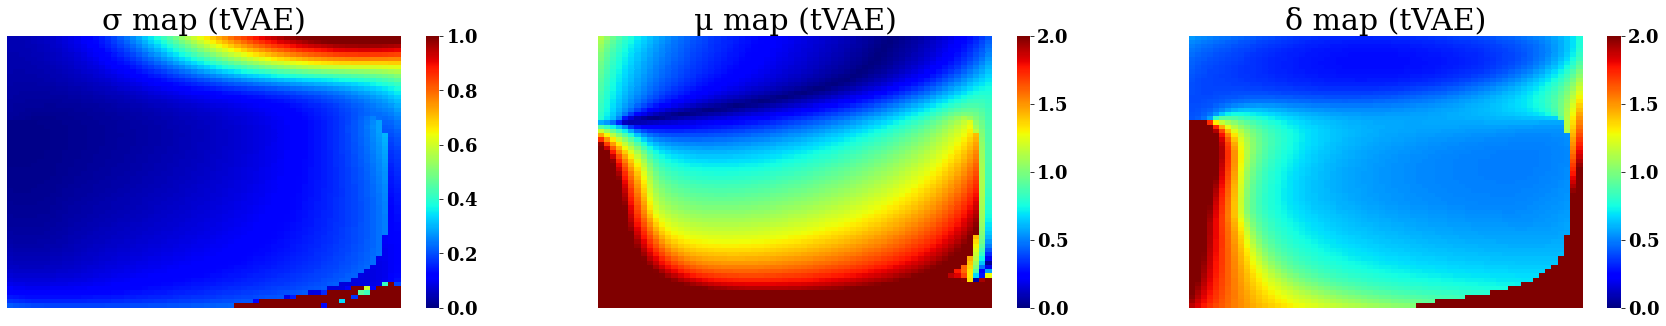

In [ ]:
#plt intensity, shift, and width maps
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "18"
plt.rcParams["axes.labelweight"] = "bold"

#plt intensity, shift, and width maps

  
fig, (ax1,ax2,ax3)= plt.subplots (1, 3,figsize=(30,5),sharex=True)
ax1 = heatmap(a_mapt,cmap= "jet",vmin=0,vmax=1,ax=ax1)
ax1.set_title ('σ map (tVAE)',fontsize=30)
ax1.set_yticks([])
ax1.set_xticks([])

ax2 = heatmap(mu_mapt,cmap= "jet", vmin=0,vmax=2,ax=ax2)
ax2.set_title ('μ map (tVAE)',fontsize=30)

ax2.set_yticks([])
ax2.set_xticks([])

ax3 = heatmap(sig_mapt,cmap= "jet",vmin=0,vmax=2,ax=ax3)
ax3.set_title ('δ map (tVAE)',fontsize=30)
ax3.set_yticks([])
ax3.set_xticks([])

plt.show()


fig.savefig('tVAE .tif', bbox_inches='tight',dpi=300)



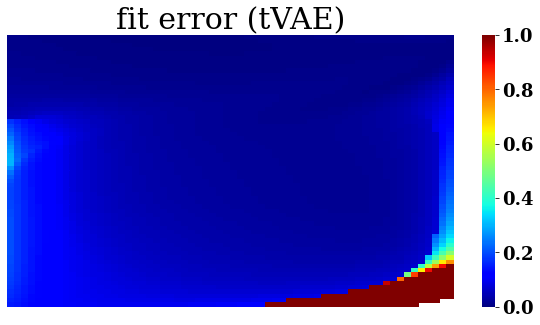

In [ ]:

fig, (ax1)= plt.subplots (nrows=1,ncols=1,figsize=(10,5))
ax1 = heatmap(amp_fmapt,cmap= "jet",vmin=0,vmax=1,ax=ax1)
ax1.set_title ('fit error (tVAE)',fontsize=30)
ax1.set_yticks([])
ax1.set_xticks([])



fig.savefig('tVAE fit error .tif', bbox_inches='tight',dpi=300)



# Continuous conditional VAE

### mu one as concentration

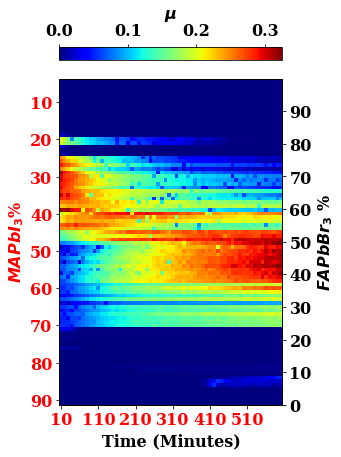

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
fig, (ax1) = plt.subplots(1, figsize=(4, 6))



im1=ax1.imshow(
X_vec_t[:, 0].reshape(d1,d2),cmap='jet')


ax1.set_xticks(np.arange(0,len(luminescence_time),10))
ax1.set_xticklabels(luminescence_time[0::10])
ax1.set_xlabel('Time (Minutes)')
ax1.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax1.set_ylabel('$MAPbI_3 $%',color='red')

ax1.tick_params(axis='both', labelcolor='red')
axins = inset_axes(ax1,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal',cax=axins,spacing='proportional')
tick_locator = ticker.MaxNLocator(nbins=4)
cbar1.locator = tick_locator
cbar1.update_ticks()
cbar1.set_label(label='$\mu$')
axins.xaxis.tick_top()
cbar1.ax.xaxis.set_label_position('top')

ax=ax1.twinx()
color= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)




mu= X_vec_t[:, 0]

fig.savefig('cVAE Shift.tif', bbox_inches='tight',dpi=300)

In [ ]:
print(train_data.shape, mu.shape)

torch.Size([5760, 176]) (5760,)


In [ ]:
# Initialize train loader
mu = torch.tensor(mu).float().unsqueeze(1)
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), mu, batch_size=64)

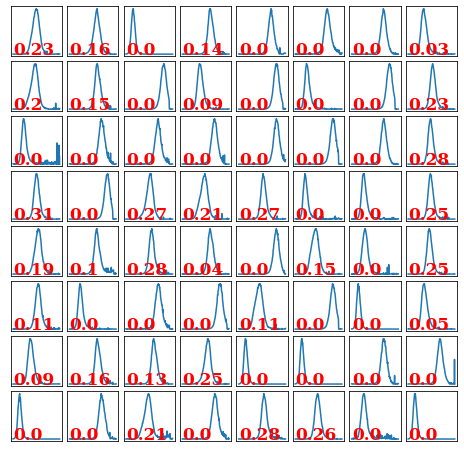

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y, m) in zip(axes.flat, train_loader):
    ax.plot(x, y[0, 0])
    # ax.set_ylim(0.25, .35)
    ax.text(0.05, 0.05, str(np.around(m[0].item(), decimals=2)),
            transform=ax.transAxes, color='red',size=17)

Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about shifts as our $c$ vector.

In [ ]:
in_dim = (l_signal,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
cvae = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, invariances=None,
                     sampler_d='gaussian', decoder_sig=0.01, seed=42)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(cvae)

# Train for n epochs:
for e in range(50):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 51250.1088
Epoch: 2 Training loss: 17532.3123
Epoch: 3 Training loss: 3211.0817
Epoch: 4 Training loss: 852.6085
Epoch: 5 Training loss: 314.4100
Epoch: 6 Training loss: 109.7940
Epoch: 7 Training loss: 1.4641
Epoch: 8 Training loss: -58.7245
Epoch: 9 Training loss: -108.1332
Epoch: 10 Training loss: -140.8664
Epoch: 11 Training loss: -170.5118
Epoch: 12 Training loss: -186.4359
Epoch: 13 Training loss: -212.4571
Epoch: 14 Training loss: -215.9046
Epoch: 15 Training loss: -224.4179
Epoch: 16 Training loss: -247.2111
Epoch: 17 Training loss: -245.7988
Epoch: 18 Training loss: -264.2754
Epoch: 19 Training loss: -278.6727
Epoch: 20 Training loss: -283.3688
Epoch: 21 Training loss: -291.3943
Epoch: 22 Training loss: -288.1618
Epoch: 23 Training loss: -309.7612
Epoch: 24 Training loss: -311.9097
Epoch: 25 Training loss: -320.1443
Epoch: 26 Training loss: -326.5456
Epoch: 27 Training loss: -321.6340
Epoch: 28 Training loss: -335.5141
Epoch: 29 Training loss: -344.2521

Encode the training data into the latent space:

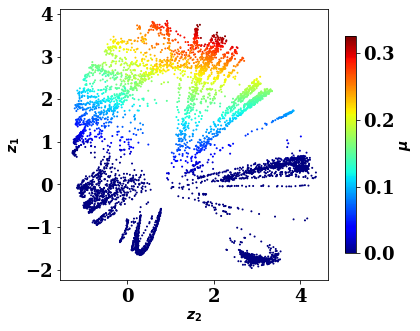

In [ ]:
z_mean, z_sd = cvae.encode(train_data)

f, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu,cmap=plt.cm.get_cmap('jet'))
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)

f.savefig('cVAE Shift manifold.tif', bbox_inches='tight',dpi=300)

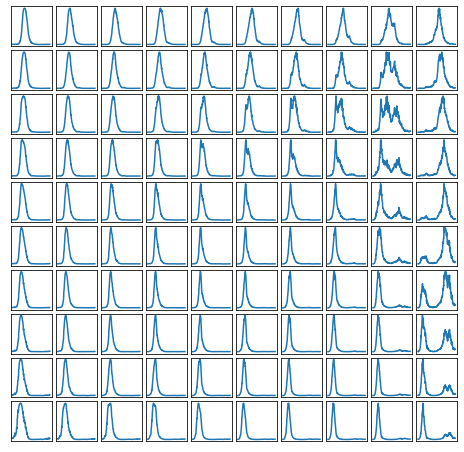

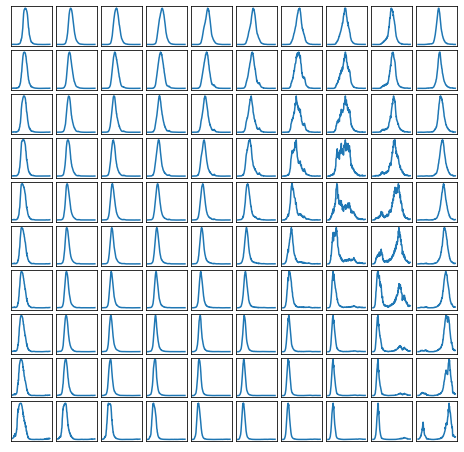

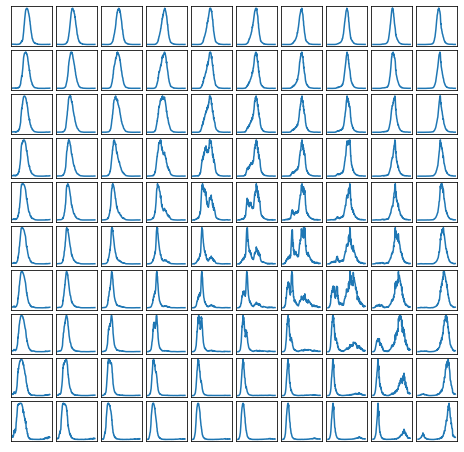

In [ ]:
y_all =[-2, 0, 2]
for y in y_all:
  y = torch.tensor(y).unsqueeze(0)
  c=10
  c_vae=cvae.manifold2d(c, y)

#c_vae=cvae.manifold2d(c,y); #z_coord = [-2,0,0,2], 
    

Plot the latent variables in the data space:

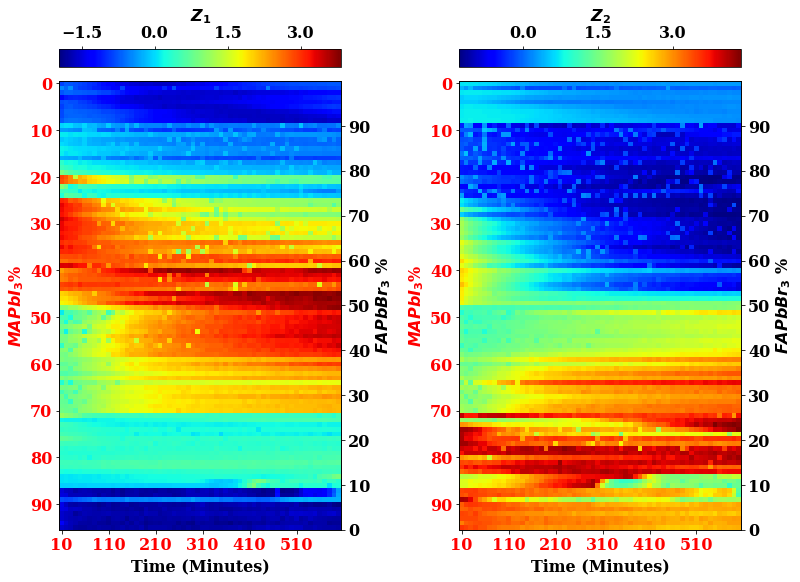

In [ ]:

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(11, 7),constrained_layout = True)
im1 = ax1.imshow(z_mean[:, 0].reshape(s1,s2), cmap='jet')


ax1.set_xticks(np.arange(0,len(luminescence_time),10))
ax1.set_xticklabels(luminescence_time[0::10])
ax1.set_xlabel('Time (Minutes)')
ax1.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax1.set_ylabel('$MAPbI_3 $%',color='red')

ax1.tick_params(axis='both', labelcolor='red')
axins = inset_axes(ax1,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal',cax=axins,spacing='proportional')
tick_locator = ticker.MaxNLocator(nbins=4)
cbar1.locator = tick_locator
cbar1.update_ticks()
cbar1.set_label(label='$Z_1$')
axins.xaxis.tick_top()
cbar1.ax.xaxis.set_label_position('top')

ax=ax1.twinx()
color= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)






im2 = ax2.imshow(z_mean[:, 1].reshape(s1,s2), cmap='jet')



ax2.set_xticks(np.arange(0,len(luminescence_time),10))
ax2.set_xticklabels(luminescence_time[0::10])
ax2.set_xlabel('Time (Minutes)')
ax2.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax2.set_ylabel('$MAPbI_3 $%',color='red')

ax2.tick_params(axis='both', labelcolor='red')
axins = inset_axes(ax2,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal',cax=axins,spacing='proportional')
tick_locator = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator
cbar2.update_ticks()
cbar2.set_label(label='$Z_2$')
axins.xaxis.tick_top()
cbar2.ax.xaxis.set_label_position('top')

ax=ax2.twinx()
coolor= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)

f.savefig('cVAE conc Latent Space plot.tif', bbox_inches='tight',dpi=300)



In [ ]:
y_all = [-2, 0, 2]
for y in y_all:
    y = torch.tensor(y).unsqueeze(0)
    c=64
    c_vae=cvae.manifold2d(c, y)


In [ ]:
def gauss(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))

def ls_parameters(f, c):         #f: manifold2d; n: grid number
  x = np.linspace (-5, 5, l_signal)
  gmodel = Model(gauss)
  latent_peak = np.zeros((c*c, 6))

  for i in range (c*c):
    y = np.array(f[i])
    mx = y.max()
    y = (y-y.min())/(y.max()-y.min())
    
    a = y.max()
    #center = np.float(x[np.where(y == a)])
    ce = sum(x * y) / sum(y)
    w = np.sqrt(sum(y * (x - ce)**2) / sum(y))

    params = gmodel.make_params(cen=ce, amp=a, wid=w)
    result = gmodel.fit(y, params, x=x)

    para=result.fit_report()
    amp_fit = result.params['amp'].stderr
   
    fit_amp = np.float(amp_fit)

    cen_fit= result.params['cen'].stderr
    fit_cen = np.float(cen_fit)
    wid_fit= result.params['wid'].stderr
    fit_wid = np.float(wid_fit)
    
    idx_amp = para.index('amp')
    d_am = para[idx_amp+6:idx_amp+16] # whats the purpose of adding the 6 and 16?
    d_amp = np.float(d_am)

    idx_mu = para.index('cen')
    d_m = para[idx_mu+6:idx_mu+16]
    d_mu = np.float(d_m)

    idx_w = para.index('wid')
    d_s = para[idx_w+6:idx_w+16]
    d_sig = np.float(d_s)

    d_a = d_amp / (sqrt(2*pi) * d_sig) * mx
    latent_peak [i,] = d_a, d_mu, d_sig,fit_amp,fit_cen,fit_wid
  
  l_a = latent_peak[:,0] 
  a_mapc = np.reshape(l_a, (c,c))
  l_mu = latent_peak[:,1] 
  mu_mapc = np.reshape(l_mu, (c,c))
  l_sig = latent_peak[:,2] 
  sig_mapc = np.reshape(l_sig, (c,c))
  f_amp= latent_peak[:,3]
  amp_fmapc=np.reshape(f_amp,(c,c))
  f_cen= latent_peak[:,4]
  cen_fmapc=np.reshape(f_cen,(c,c))
  f_wid= latent_peak[:,5]
  wid_fmapc=np.reshape(f_wid,(c,c))

  return a_mapc, mu_mapc, sig_mapc,amp_fmapc,cen_fmapc,wid_fmapc

In [ ]:
#vae latent space
a_mapc, mu_mapc, sig_mapc,amp_fmapc,cen_fmapc,wid_fmapc = ls_parameters(c_vae, c)     #input VAE manifold2D and grid number to the function ls_parameters and return intensity, shift, and width maps

#plt intensity, shift, and width maps
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "18"
plt.rcParams["axes.labelweight"] = "bold"

#plt intensity, shift, and width maps
fig, (ax1,ax2,ax3)= plt.subplots (nrows=1,ncols=3,figsize=(30,5))
ax1 = heatmap(a_mapc,cmap= "jet",vmin=0,vmax=1,ax=ax1)
ax1.set_title ('cVAE Concentration σ map',fontsize=30)
ax1.set_yticks([])
ax1.set_xticks([])

ax2 = heatmap(mu_mapc,cmap= "jet", vmin=0,vmax=2,ax=ax2)
ax2.set_title ('cVAE Concentration μ map',fontsize=30)

ax2.set_yticks([])
ax2.set_xticks([])


ax3 = heatmap(sig_mapc,cmap= "jet",vmin=0,vmax=2,ax=ax3)
ax3.set_title ('cVAE Concentration δ map',fontsize=30)
ax3.set_yticks([])
ax3.set_xticks([])

plt.show()


fig.savefig('cVAE plots maps.tif', bbox_inches='tight',dpi=300)
    


In [ ]:

fig, (ax1)= plt.subplots (nrows=1,ncols=1,figsize=(10,5))
ax1 = heatmap(amp_fmapc,cmap= "jet",vmin=0,vmax=1,ax=ax1)
ax1.set_title ('cVAE Concentration fit error',fontsize=30)
ax1.set_yticks([])
ax1.set_xticks([])


fig.savefig('cVAE plots error.tif', bbox_inches='tight',dpi=300)

### mu two: Position of peak maximum

In [ ]:
mu_two=np.argmax(hdata,axis=1)

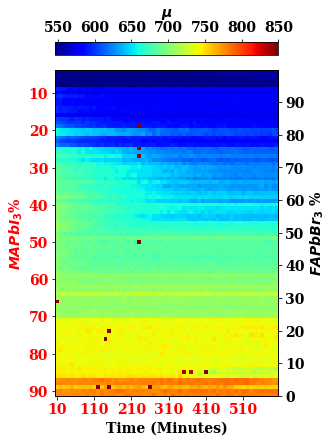

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "14"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
fig, (ax1) = plt.subplots(1, figsize=(4, 6))




im1=ax1.imshow(mu_two.reshape(d1,d2),cmap='jet')




ax1.set_xticks(np.arange(0,len(luminescence_time),10))
ax1.set_xticklabels(luminescence_time[0::10])
ax1.set_xlabel('Time (Minutes)')
ax1.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax1.set_ylabel('$MAPbI_3 $%',color='red')

ax1.tick_params(axis='both', labelcolor='red')
axins = inset_axes(ax1,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal',cax=axins,spacing='proportional')
tick_locator = ticker.MaxNLocator(nbins=4)
cbar1.locator = tick_locator
cbar1.update_ticks()
cbar1.set_label(label='$\mu$')
axins.xaxis.tick_top()
cbar1.ax.xaxis.set_label_position('top')

cbar1.set_ticks(np.arange(0,len(luminescence_wavelength),25))
cbar1.set_ticklabels(luminescence_wavelength[0::25])

ax=ax1.twinx()
color= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)


fig.savefig('cVAE conc.tif', bbox_inches='tight',dpi=300)

In [ ]:
mu_two

array([ 24,  25,  25, ..., 144, 143, 141])

In [ ]:
mu_two.shape

(5760,)

In [ ]:
# Initialize train loader
mu_two = torch.tensor(mu_two).float().unsqueeze(1)
train_loader= pv.utils.init_dataloader(train_data.unsqueeze(1), mu_two, batch_size=64)

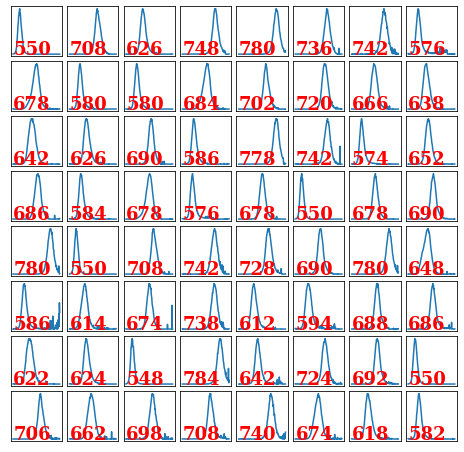

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y, m) in zip(axes.flat, train_loader):
    ax.plot(x, y[0,0])
    # ax.set_ylim(0.25, .35)
    m = m.type(torch.int64)
    T = [luminescence_wavelength[i] for i in m]

    
    ax.text(0.05, 0.05, str(np.around(T[0].item(), decimals=4)),
            transform=ax.transAxes, color='red',size=18)



In [ ]:
in_dim = (l_signal,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
cvae = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, invariances=None,
                     sampler_d='gaussian', decoder_sig=0.01, seed=42)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(cvae)

# Train for n epochs:
for e in range(50):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 46230.2845
Epoch: 2 Training loss: 30002.5154
Epoch: 3 Training loss: 21707.2291
Epoch: 4 Training loss: 13530.2813
Epoch: 5 Training loss: 4645.3990
Epoch: 6 Training loss: 1589.9973
Epoch: 7 Training loss: 692.7012
Epoch: 8 Training loss: 334.3405
Epoch: 9 Training loss: 156.8599
Epoch: 10 Training loss: 59.0052
Epoch: 11 Training loss: 7.5554
Epoch: 12 Training loss: -71.3101
Epoch: 13 Training loss: -105.6969
Epoch: 14 Training loss: -145.5436
Epoch: 15 Training loss: -168.2232
Epoch: 16 Training loss: -183.0945
Epoch: 17 Training loss: -208.9892
Epoch: 18 Training loss: -222.8843
Epoch: 19 Training loss: -244.8296
Epoch: 20 Training loss: -251.9820
Epoch: 21 Training loss: -260.7506
Epoch: 22 Training loss: -276.4233
Epoch: 23 Training loss: -291.5727
Epoch: 24 Training loss: -292.6505
Epoch: 25 Training loss: -309.3654
Epoch: 26 Training loss: -290.4660
Epoch: 27 Training loss: -314.9375
Epoch: 28 Training loss: -330.3277
Epoch: 29 Training loss: -337.5571

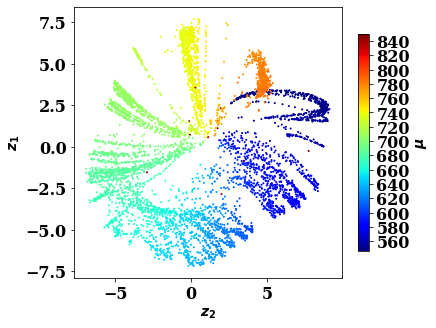

In [ ]:
z_mean, z_sd = cvae.encode(train_data)

f, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu_two,cmap=plt.cm.get_cmap('jet'))
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
cbar1.set_ticks(np.arange(0,len(luminescence_wavelength),10))
cbar1.set_ticklabels(luminescence_wavelength[0::10])

f.savefig('cVAE pos of peak max.tif', bbox_inches='tight',dpi=300)

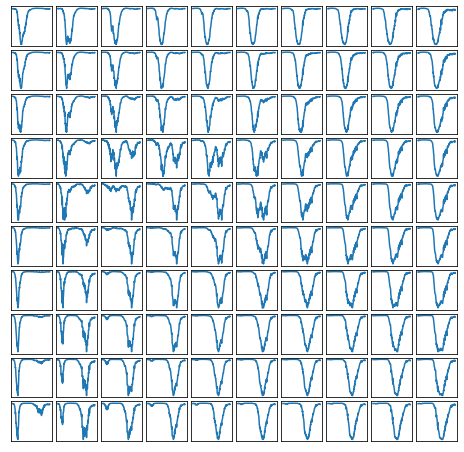

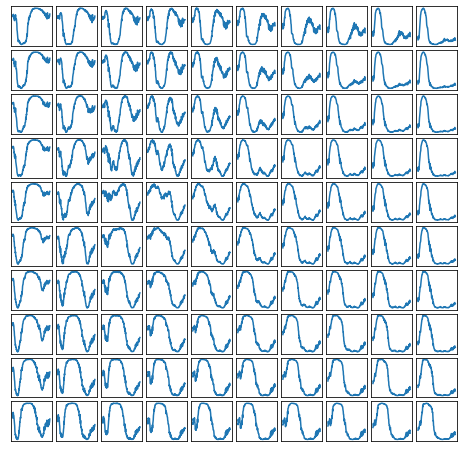

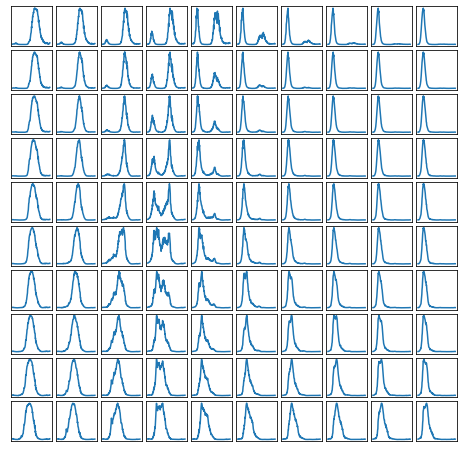

In [ ]:
y_all = [-2, 0, 2]
for y in y_all:
    y = torch.tensor(y).unsqueeze(0)
    c=10
    c_vae=cvae.manifold2d(c, y)

    

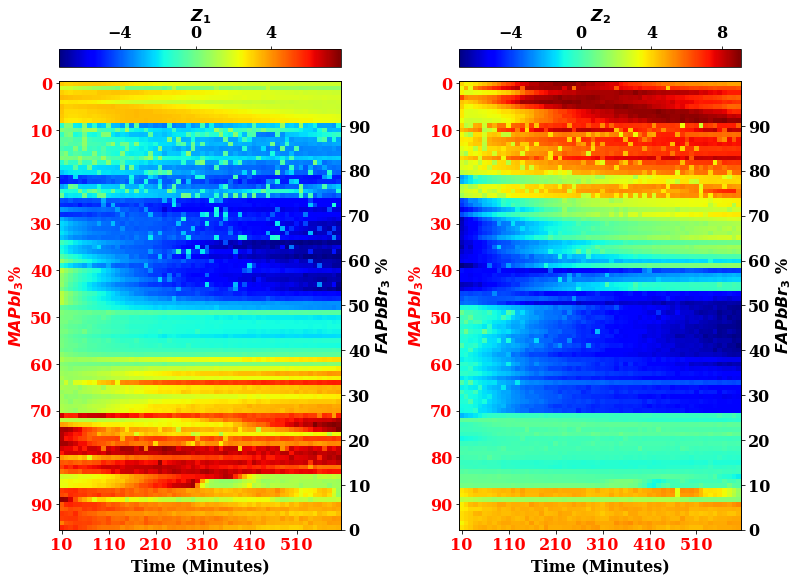

In [ ]:


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7),constrained_layout=True )

im1 = ax1.imshow(z_mean[:, 0].reshape(s1,s2), cmap='jet')


ax1.set_xticks(np.arange(0,len(luminescence_time),10))
ax1.set_xticklabels(luminescence_time[0::10])
ax1.set_xlabel('Time (Minutes)')
ax1.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax1.set_ylabel('$MAPbI_3 $%',color='red')

ax1.tick_params(axis='both', labelcolor='red')
axins = inset_axes(ax1,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal',cax=axins,spacing='proportional')
tick_locator = ticker.MaxNLocator(nbins=4)
cbar1.locator = tick_locator
cbar1.update_ticks()
cbar1.set_label(label='$Z_1$')
axins.xaxis.tick_top()
cbar1.ax.xaxis.set_label_position('top')

ax=ax1.twinx()
color= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)

im2 = ax2.imshow(z_mean[:, 1].reshape(s1,s2), cmap='jet')


ax2.set_xticks(np.arange(0,len(luminescence_time),10))
ax2.set_xticklabels(luminescence_time[0::10])
ax2.set_xlabel('Time (Minutes)')
ax2.set_yticks(np.arange(0,len(composition.iloc[0,:]),10))
ax2.set_ylabel('$MAPbI_3 $%',color='red')

ax2.tick_params(axis='both', labelcolor='red')
axins = inset_axes(ax2,
                    width="100%",  
                    height="4%",
                    loc='upper center',
                    borderpad=-2
                   )
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal',cax=axins,spacing='proportional')
tick_locator = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator
cbar2.update_ticks()
cbar2.set_label(label='$Z_2$')
axins.xaxis.tick_top()
cbar2.ax.xaxis.set_label_position('top')

ax=ax2.twinx()
coolor= 'black'
ax.set_ylabel("$FAPbBr_3$ %", color=color)
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim((0, 100))
ax.tick_params(axis='y', labelcolor=color)
f.savefig('cVAE plots max .tif', bbox_inches='tight',dpi=300)

In [ ]:
y_all = [-2, 0, 2]
for y in y_all:
    y = torch.tensor(y).unsqueeze(0)
    c=64
    c_vae=cvae.manifold2d(c, y)


In [ ]:
def gauss(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))

def ls_parameters(f, c):         #f: manifold2d; n: grid number
  x = np.linspace (-5, 5, l_signal)
  gmodel = Model(gauss)
  latent_peak = np.zeros((c*c, 6))

  for i in range (c*c):
    y = np.array(f[i])
    mx = y.max()
    y = (y-y.min())/(y.max()-y.min())
    
    a = y.max()
    #center = np.float(x[np.where(y == a)])
    ce = sum(x * y) / sum(y)
    w = np.sqrt(sum(y * (x - ce)**2) / sum(y))

    params = gmodel.make_params(cen=ce, amp=a, wid=w)
    result = gmodel.fit(y, params, x=x)

    para=result.fit_report()
    amp_fit = result.params['amp'].stderr
   
    fit_amp = np.float(amp_fit)

    cen_fit= result.params['cen'].stderr
    fit_cen = np.float(cen_fit)
    wid_fit= result.params['wid'].stderr
    fit_wid = np.float(wid_fit)
    
    idx_amp = para.index('amp')
    d_am = para[idx_amp+6:idx_amp+16] # whats the purpose of adding the 6 and 16?
    d_amp = np.float(d_am)

    idx_mu = para.index('cen')
    d_m = para[idx_mu+6:idx_mu+16]
    d_mu = np.float(d_m)

    idx_w = para.index('wid')
    d_s = para[idx_w+6:idx_w+16]
    d_sig = np.float(d_s)

    d_a = d_amp / (sqrt(2*pi) * d_sig) * mx
    latent_peak [i,] = d_a, d_mu, d_sig,fit_amp,fit_cen,fit_wid
  
  l_a = latent_peak[:,0] 
  a_mapc = np.reshape(l_a, (c,c))
  l_mu = latent_peak[:,1] 
  mu_mapc = np.reshape(l_mu, (c,c))
  l_sig = latent_peak[:,2] 
  sig_mapc = np.reshape(l_sig, (c,c))
  f_amp= latent_peak[:,3]
  amp_fmapc=np.reshape(f_amp,(c,c))
  f_cen= latent_peak[:,4]
  cen_fmapc=np.reshape(f_cen,(c,c))
  f_wid= latent_peak[:,5]
  wid_fmapc=np.reshape(f_wid,(c,c))

  return a_mapc, mu_mapc, sig_mapc,amp_fmapc,cen_fmapc,wid_fmapc

In [ ]:
#vae latent space
a_mapc, mu_mapc, sig_mapc,amp_fmapc,cen_fmapc,wid_fmapc = ls_parameters(c_vae, c)     #input VAE manifold2D and grid number to the function ls_parameters and return intensity, shift, and width maps

#plt intensity, shift, and width maps
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.size"] = "18"
plt.rcParams["axes.labelweight"] = "bold"

#plt intensity, shift, and width maps
fig, (ax1,ax2,ax3)= plt.subplots (nrows=1,ncols=3,figsize=(30,5))
ax1 = heatmap(a_mapc,cmap= "jet",vmin=0,vmax=1,ax=ax1)
ax1.set_title ('σ mapc',fontsize=30)
ax1.set_yticks([])
ax1.set_xticks([])

ax2 = heatmap(mu_mapc,cmap= "jet", vmin=0,vmax=2,ax=ax2)
ax2.set_title ('μ mapc',fontsize=30)

ax2.set_yticks([])
ax2.set_xticks([])


ax3 = heatmap(sig_mapc,cmap= "jet",vmin=0,vmax=2,ax=ax3)
ax3.set_title ('δ mapc',fontsize=30)
ax3.set_yticks([])
ax3.set_xticks([])

plt.show()


fig.savefig('cVAE plots maps pos max.tif', bbox_inches='tight',dpi=300)

    


In [ ]:

fig, (ax1)= plt.subplots (nrows=1,ncols=1,figsize=(10,5))
ax1 = heatmap(amp_fmapc,cmap= "jet",vmin=0,vmax=1,ax=ax1)
ax1.set_title ('fit error',fontsize=30)
ax1.set_yticks([])
ax1.set_xticks([])


fig.savefig('cVAE plots error pos maxtif', bbox_inches='tight',dpi=300)